In [7]:
import tensorflow as tf;
import numpy as np
import matplotlib.pyplot as plt


In [8]:
img = tf.image.decode_jpeg(tf.io.read_file('../kaggle/cat-and-dog/training_set/dogs/dog.66.jpg'))

In [9]:
img.shape

TensorShape([397, 499, 3])

In [36]:
def draw_ab(images, boxes):
    images = tf.cast(images, dtype='float32')
    if len(images.shape) == 3:
        images = tf.reshape(images, shape=(1, *images.shape))
    if len(boxes.shape) == 1:
        boxes = tf.reshape(boxes, shape=(1, 1, *boxes.shape))
    elif len(boxes.shape) == 2:
        boxes = tf.reshape(boxes, shape=(1, *boxes.shape))
    colors = tf.random.uniform(shape=(*boxes.shape[:2], 4), minval=0, maxval=255, dtype='float32')
    colors = tf.reshape(colors, (-1, 4))
    return tf.image.draw_bounding_boxes(images=images, boxes=boxes, colors=colors)

def im_show(images):
    [plt.imshow(tf.cast(images[i], dtype='int32')) for i in range(len(images))]

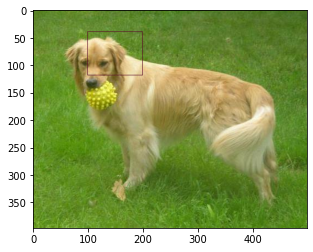

In [39]:
boxed = draw_ab(img, tf.constant([0.1,0.2,0.3,0.4], dtype='float32'))
im_show(boxed)

In [47]:
def get_all_boxes(img, scales, ratios):
    img = tf.cast(img, dtype='float32')
    # output.shape: (pixel_h, pixel_w, n_boxes_per_pixel, box) 

    pairs = [(scales[0], np.sqrt(ratio)) for ratio in ratios]
    pairs += [(scale, np.sqrt(ratios[0])) for scale in scales]
    pairs = tf.constant(pairs, dtype='float32')
    # scales = tf.constant(scales, dtype='float32')
    # ratios = tf.constant(ratios, dtype='float32')
    
    # 取出图片的宽高
    img_h, img_w, _ = img.shape
    n_boxes_per_pixel = len(scales) + len(ratios) - 1
    
    # 1 * 1 --- 21 * 2 * 1
    # 1 * 397 --- 1 * 499    pairs:  7 * 2   397 * 7 * 1
    boxes_center_h = tf.expand_dims((tf.constant(tf.range(img_h, dtype='float32'), dtype='float32') + .5) * 1. / img_h, axis=-1)
    boxes_center_w = tf.expand_dims((tf.constant(tf.range(img_w, dtype='float32'), dtype='float32') + .5) * 1. / img_w, axis=-1)

    pairs = tf.repeat(pairs, repeats=len(boxes_center_h), axis=0)
    # 1 * 500
    boxes_h = boxes_center_h * pairs[:, 0, :] * pairs[:, 1, :]
    boxes_w = boxes_center_w * pairs[:, 0, :] * pairs[:, 1, :]
    

In [49]:
get_all_boxes(img=img, scales=[.5, .75, .25, 1], ratios=[.5, .75, .25])

2022-05-24 17:27:12.616373: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at strided_slice_op.cc:108 : INVALID_ARGUMENT: Index out of range using input dim 2; input has only 2 dims


InvalidArgumentError: Index out of range using input dim 2; input has only 2 dims [Op:StridedSlice] name: strided_slice/